### Import Libraries

In [3]:
import sys
sys.path.insert(1, '../scripts')
import extended_model
import analysis_helper
import importlib
import glob
import json
importlib.reload(extended_model)
importlib.reload(analysis_helper)

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

import numpy as np
import bisect
import itertools
from functools import reduce
from operator import mul
from scipy.stats import norm
import random
from math import comb

import multiprocessing as mp

from tqdm import tqdm

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 14

### Run the simulation

In [4]:
pool = mp.Pool(processes=32)

simulation_count = 100
n_nodes = 3
N = 300
p = .2
params = [*zip([*range(simulation_count)], [n_nodes]*simulation_count, [N]*simulation_count, [p]*simulation_count)]

results = pool.starmap(extended_model.simulate, params)
graphs = [r[1] for r in results]
results = {sim_no:track for sim_no,track in [r[0] for r in results]}

 32%|███▏      | 17201/54001 [00:07<00:15, 2438.09it/s]

 33%|███▎      | 18000/54001 [00:07<00:14, 2461.68it/s]

 45%|████▌     | 24540/54001 [00:09<00:11, 2489.90it/s]


# Analysis

## Only One Simulation 

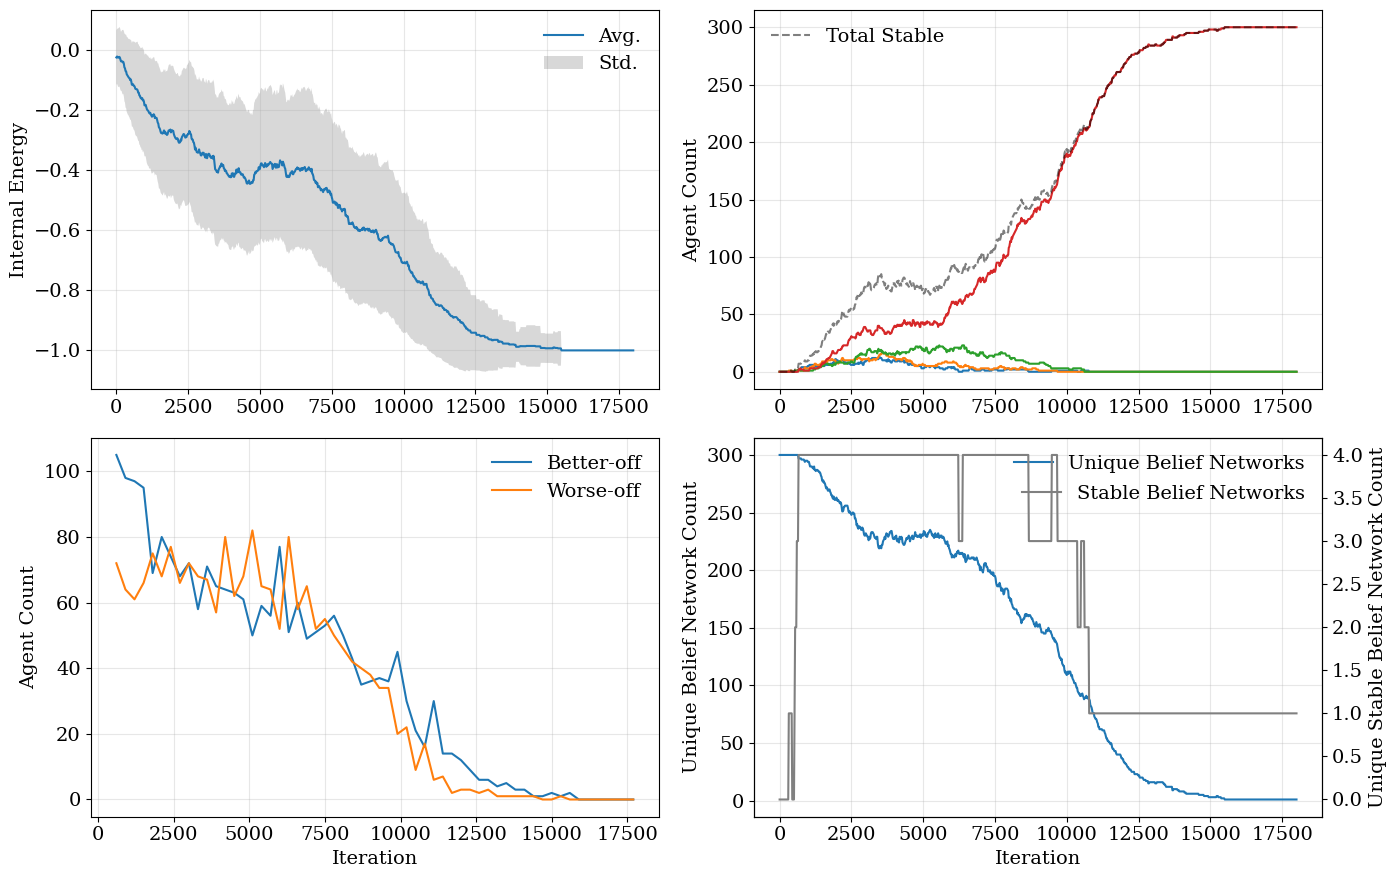

In [5]:
i = 23
track = results[i]
analysis_helper.overall_analysis(n_nodes, track)

In [7]:
def save_figures(iteration):
    plt.figure(figsize=(10,10))
    nx.draw(G, pos, width=.15, node_color = [c['color'] for c in track[iteration]['node_coloring'].values()])
    plt.savefig(f'../figures/graph_animation/{iteration}.png')

In [11]:
G = graphs[i]
pos = nx.spring_layout(G=G, seed=89)

pool = mp.Pool(processes=32)
pool.map(save_figures, [i for i in track.keys() if i%100==0])

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

## All Simulations Together

### Run the analyses

In [4]:
internal_energy_analysis_data_sum = extended_model.internal_energy_analysis(results)
better_off_worse_off_data_sum = extended_model.better_off_worse_off_analysis(results)
stability_analysis_data_sum = extended_model.stability_analysis(results, n_nodes = n_nodes)
unique_belief_count_analysis_sum = extended_model.unique_belief_count_analysis(results)
unique_stable_network_count_sum = extended_model.unique_stable_network_count_analysis(results, n_nodes = n_nodes)

### Save the results

In [ ]:
temp = internal_energy_analysis_data_sum.copy()
for _ in ['avg', 'upper', 'lower']:
    temp[_] = temp[_].tolist()

with open('../data/internal_energy_analysis_data_sum.json', 'w') as f:
    json.dump(temp, f)

In [ ]:
temp = better_off_worse_off_data_sum.copy()
for c in ['better_off', 'worse_off']:
    for _ in ['avg', 'upper', 'lower']:
        temp[c][_] = temp[c][_].tolist()

with open('../data/better_off_worse_off_data_sum.json', 'w') as f:
    json.dump(temp, f)

In [ ]:
with open('../data/stability_analysis_data.json', 'w') as f:
    json.dump(stability_analysis_data, f, default=float)

### Visualize

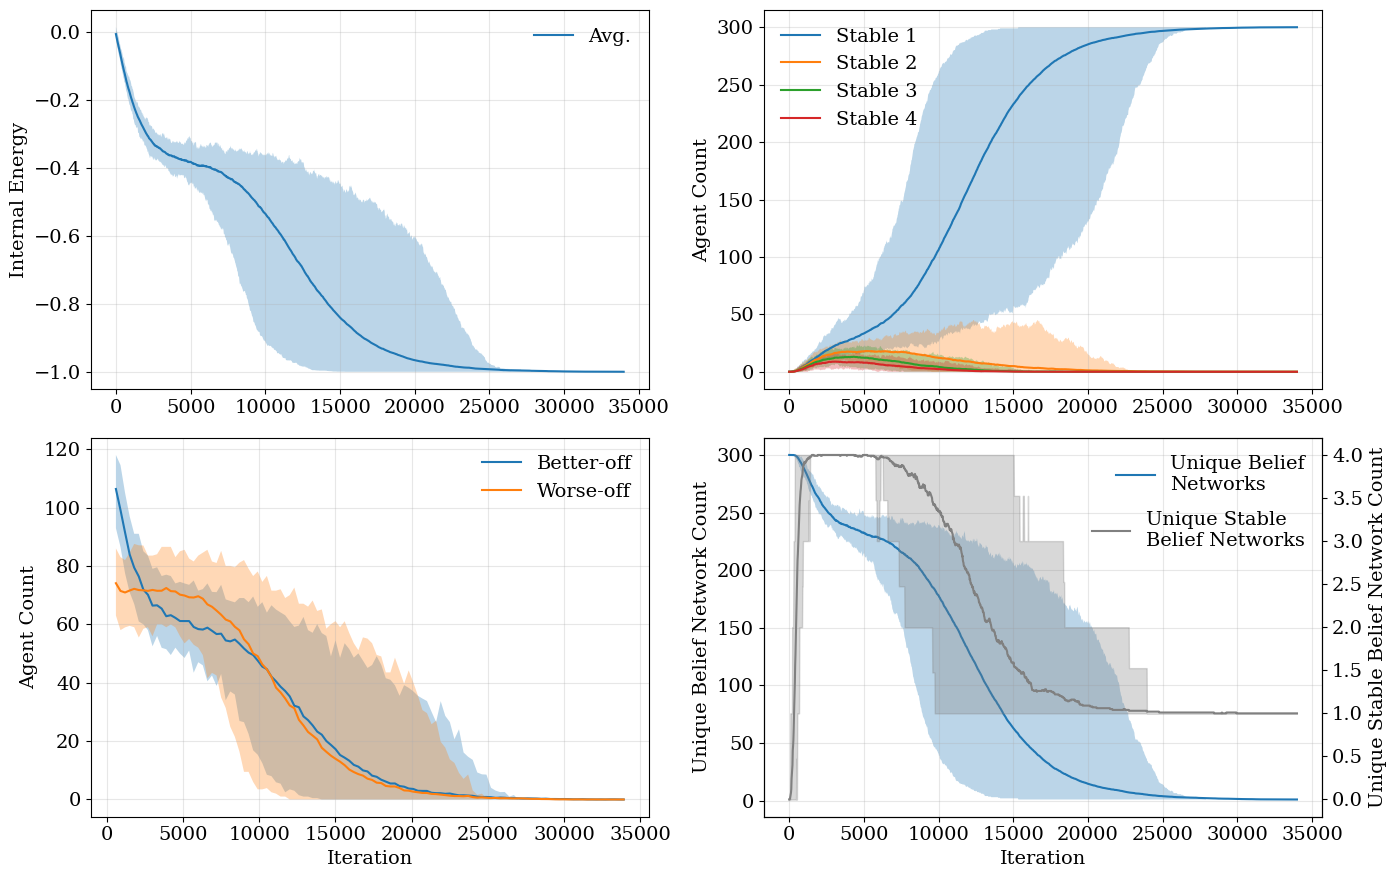

In [82]:
fig, axs = plt.subplots(2,2,figsize=(14,9))

for row, col, d, l in zip([0,1,1,0,0,0,0,1],
                        [0,0,0,1,1,1,1,1],
                        [internal_energy_analysis_data_sum, 
                        better_off_worse_off_data_sum['better_off'], better_off_worse_off_data_sum['worse_off'],
                        stability_analysis_data_sum[0], stability_analysis_data_sum[1], stability_analysis_data_sum[2], stability_analysis_data_sum[3],
                        unique_belief_count_analysis_sum],
                        ['Avg.','Better-off', 'Worse-off','Stable 1','Stable 2','Stable 3','Stable 4','Unique Belief\nNetworks']):

    x = [i*20 for i in d['x']] if (l != 'Better-off') & (l != 'Worse-off') & (l != 'Unique Belief\nNetworks') else d['x']

    axs[row][col].plot(x, d['avg'], label=l)
    axs[row][col].fill_between(x, d['lower'], d['upper'], alpha=.3)

for row,col,l in zip([0,0,1,1],[0,1,0,1], ['Internal Energy', 'Agent Count', 'Agent Count','Unique Belief Network Count']):
    axs[row][col].grid(alpha=.3)
    axs[row][col].set_ylabel(l)
    
    axs[row][col].legend(frameon=False)

axs[1][1].set_xlabel('Iteration')
axs[1][0].set_xlabel('Iteration')

loc = plticker.MultipleLocator(base=1.0)

axs2 = axs[1][1].twinx()
axs2.plot(x,
        unique_stable_network_count_sum['avg'],
        color='gray',
        label='Unique Stable\nBelief Networks'
        )

axs2.fill_between(x, 
                unique_stable_network_count_sum['lower'],
                unique_stable_network_count_sum['upper'], 
                alpha=.3, 
                color='gray',
                )

axs2.set_ylabel('Unique Stable Belief Network Count')
axs2.legend(frameon=False, bbox_to_anchor=(0., .75, 1., .102))


fig.tight_layout()
fig.show()